In [1]:
import numpy as np
from numpy import mean,std
from random import randint
import pandas as pd

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,RobustScaler,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D,add,BatchNormalization,Activation,AveragePooling2D,Dropout
from keras.layers import Conv1D,MaxPooling1D
from keras.layers import LSTM
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model,Model
from keras.backend import placeholder
from keras.initializers import glorot_uniform
from keras.utils import multi_gpu_model
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf

import h5py
from zipfile import ZipFile
import pydot
from numba import jit,cuda
import scipy
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.interpolation import map_coordinates


import scipy.io as sio
import itertools 

from os import listdir
from os.path import isfile, join

import datetime as dt
import random

from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (16,8)


Using TensorFlow backend.
/Users/Allu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Allu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Allu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Allu/opt/anaconda3/lib/python3.7/site-pa

In [2]:
Data = pd.read_csv('PowerConsumption_univariate.csv',low_memory = False,header = 0,index_col = 0)

/Users/Allu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
Data.index = Data['datetime']

In [5]:
Data.index = pd.to_datetime(Data.index)

In [6]:
Data = Data.drop(['datetime'],axis = 1)

In [7]:
# convert data to hourly data 
Data_hr = pd.DataFrame(Data).resample('H').mean()


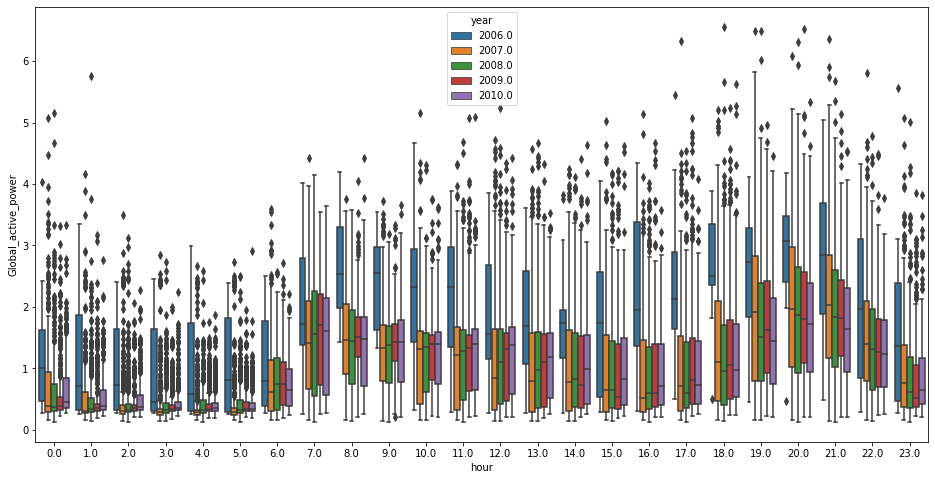

In [8]:
sns.boxplot(x= 'hour',y = 'Global_active_power',data = Data_hr,hue = 'year')

In [9]:
Df = Data[Data['year'] == 2006]

In [10]:
Data_new = Data[Df.shape[0]:]

In [11]:
Data_hr = pd.DataFrame(Data_new).resample('H').mean()

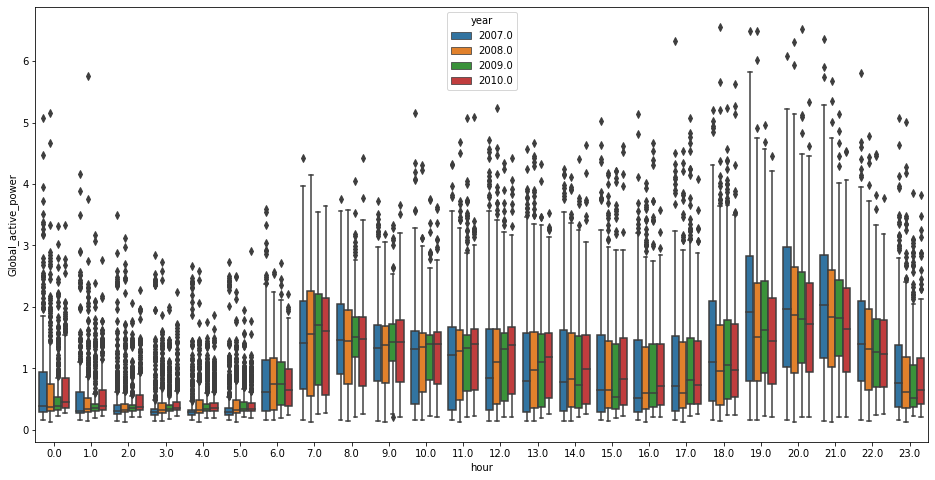

In [12]:
sns.boxplot(x= 'hour',y = 'Global_active_power',data = Data_hr,hue = 'year')

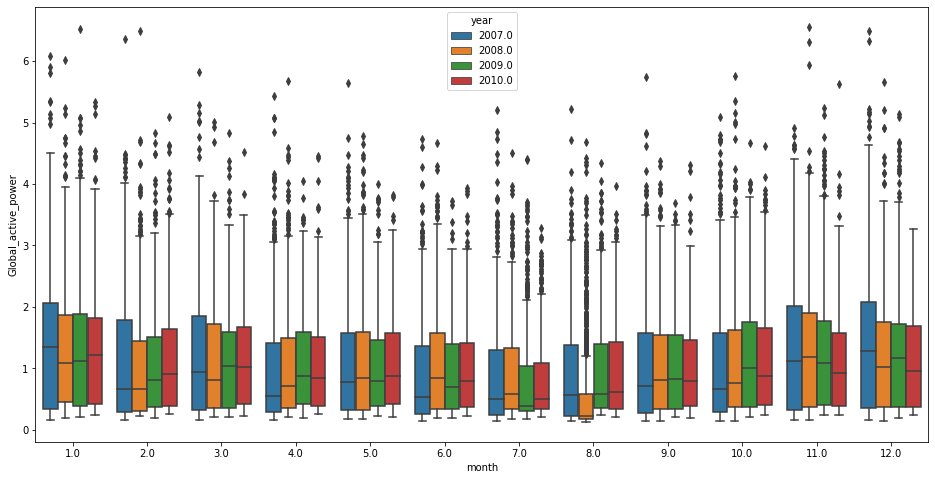

In [13]:
sns.boxplot(x= 'month',y = 'Global_active_power',data = Data_hr,hue = 'year')

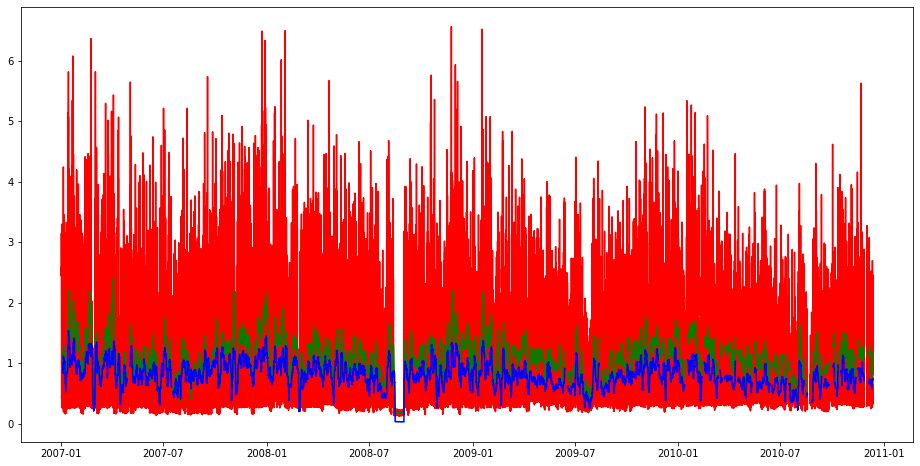

In [14]:
# convert to supervised variables to perform the time series forecasting
plt.plot(Data_hr.Global_active_power,'-r')
plt.plot(Data_hr.Global_active_power.rolling(window = 72).mean(),'-g')
plt.plot(Data_hr.Global_active_power.rolling(window =72).std(),'-b')

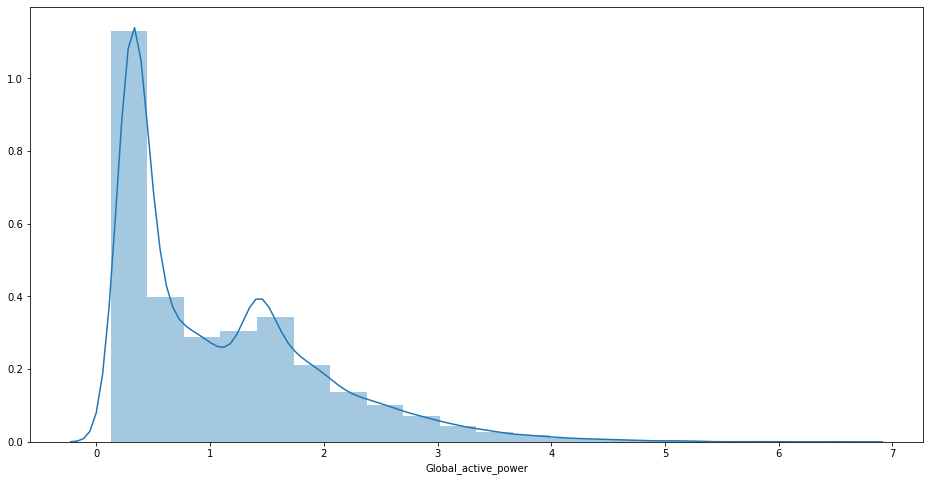

In [15]:
sns.distplot(Data_hr.Global_active_power,bins = 20)

In [78]:
Data_week = Data.Global_active_power.resample('W').mean()

In [16]:
def to_supervised(X,n_t,n_o,f):
    
    names = list()
    cols = list()

    for j in range(f):
    
        for k in range(n_t,0,-1):
            
            col = X[X.columns[j]].shift(k)
            cols.append(col)
            names +=[('var'+str(j+1)+'(t'+str('%+d')+')') %-k]
            
    
        
    for j in range(f):
        
        for k in range(0,n_o):
       
        
            
        
            if k == 0:
                col = X[X.columns[j]].shift(k)
                cols.append(col)
                names+= [('var'+str(j+1)+'(t)')]
             
            else:
                col = X[X.columns[j]].shift(k)
                cols.append(col)
                names +=[('var'+str(j+1)+'(t'+str('%+d')+')') %k]
                
    
    
    
    Dataset = pd.concat(cols,axis =1)
    Dataset.columns = names            
    Dataset.dropna(inplace = True)  
    
    
    
    return names,Dataset   

In [18]:
n_t = 5
n_o = 1
f = len(Data_hr.columns)
names,Data_supervised = to_supervised(Data_hr,n_t,n_o,f)


In [19]:
Data_supervised

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var2(t-5),var2(t-4),var2(t-3),var2(t-2),var2(t-1),...,var8(t-2),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-01 05:00:00,2.550633,2.523400,2.582333,2.541667,2.475733,2007.0,2007.0,2007.0,2007.0,2007.0,...,1.0,1.0,2.476233,2007.0,1.0,1.0,1.0,5.0,1.0,1.0
2007-01-01 06:00:00,2.523400,2.582333,2.541667,2.475733,2.476233,2007.0,2007.0,2007.0,2007.0,2007.0,...,1.0,1.0,2.455800,2007.0,1.0,1.0,1.0,6.0,1.0,1.0
2007-01-01 07:00:00,2.582333,2.541667,2.475733,2.476233,2.455800,2007.0,2007.0,2007.0,2007.0,2007.0,...,1.0,1.0,2.447200,2007.0,1.0,1.0,1.0,7.0,1.0,1.0
2007-01-01 08:00:00,2.541667,2.475733,2.476233,2.455800,2.447200,2007.0,2007.0,2007.0,2007.0,2007.0,...,1.0,1.0,2.441733,2007.0,1.0,1.0,1.0,8.0,1.0,1.0
2007-01-01 09:00:00,2.475733,2.476233,2.455800,2.447200,2.441733,2007.0,2007.0,2007.0,2007.0,2007.0,...,1.0,1.0,3.146133,2007.0,1.0,1.0,1.0,9.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-11 19:00:00,1.320933,1.790767,1.361667,2.456100,2.280867,2010.0,2010.0,2010.0,2010.0,2010.0,...,49.0,49.0,2.391967,2010.0,4.0,12.0,11.0,19.0,0.0,49.0
2010-12-11 20:00:00,1.790767,1.361667,2.456100,2.280867,2.391967,2010.0,2010.0,2010.0,2010.0,2010.0,...,49.0,49.0,1.753333,2010.0,4.0,12.0,11.0,20.0,0.0,49.0
2010-12-11 21:00:00,1.361667,2.456100,2.280867,2.391967,1.753333,2010.0,2010.0,2010.0,2010.0,2010.0,...,49.0,49.0,1.114900,2010.0,4.0,12.0,11.0,21.0,0.0,49.0


In [20]:
Data_model = Data_supervised[Data_supervised.columns[:n_t*f+n_o]]

In [22]:
Values = Data_model.values
Values = Values.astype('float32')

In [23]:
m = int(Values.shape[0])
tr = int(0.9*m)


In [24]:
Values.shape

(33696, 41)

In [25]:
def split_train_test(Xs,ts,n_t,n_o,f):
    
    X_in = Xs[:,:n_t*f]
    Y = Xs[:,-n_o:]
    
    X_train = X_in[:ts,:]
    Y_train = Y[:ts]
    X_test = X_in[ts:,:]
    Y_test = Y[ts:]
    
    return X_train,Y_train,X_test,Y_test


In [26]:
X_train,Y_train,X_test,Y_test = split_train_test(Values,tr,n_t,n_o,f)

In [27]:
X_train.shape

(30326, 40)

In [28]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
Y_train_scaled = scaler.fit_transform(Y_train)
X_test_scaled = scaler.fit_transform(X_test)
Y_test_scaled = scaler.fit_transform(Y_test)

In [51]:
def CNN1D_model(X1,Y1,X2,Y2):
    m = X1.shape[1]
    n = X1.shape[2]
    Xi = Input((m,n))
    X = Conv1D(filters = 64,kernel_size = 2,activation = 'sigmoid',input_shape = (m,n),name = 'conv1')(Xi)
    X = MaxPooling1D(pool_size = 2)(X)
    X = Flatten()(X)
    X = Dense(100,activation = 'relu',name ='FC1')(X)
    X = Dense(1,name = 'FC2')(X)
    model = Model(inputs = Xi,outputs = X)
    opt = Adam(learning_rate = 0.007)
    model.compile(optimizer = opt,loss = 'mse',metrics=['mae'])
    history = model.fit(X1,Y1,epochs = 20,batch_size = 512,verbose = 1,shuffle = False)
    model.summary()
    return model,history

    

In [52]:
#convert shape from [samples,timesteps] to [samples,timesteps,features(output features)]

def reshape_train_test(X1,X2,n_o):
    X11 = X1.reshape(X1.shape[0],X1.shape[1],n_o)
    X22 = X2.reshape(X2.shape[0],X2.shape[1],n_o)
    
    return X11,X22

In [53]:
X_train1,X_test1 = reshape_train_test(X_train_scaled,X_test_scaled,n_o)

In [54]:
X_train1.shape

(30326, 40, 1)

Epoch 1/20
30326/30326 [==============================] - 6s 206us/step - loss: 3.7574 - mae: 0.4450
Epoch 2/20
30326/30326 [==============================] - 5s 180us/step - loss: 0.0266 - mae: 0.1125
Epoch 3/20
30326/30326 [==============================] - 6s 185us/step - loss: 0.0233 - mae: 0.1101
Epoch 4/20
30326/30326 [==============================] - 6s 183us/step - loss: 0.0212 - mae: 0.1098
Epoch 5/20
30326/30326 [==============================] - 6s 181us/step - loss: 0.0203 - mae: 0.1106
Epoch 6/20
30326/30326 [==============================] - 6s 193us/step - loss: 0.0199 - mae: 0.1117
Epoch 7/20
30326/30326 [==============================] - 6s 201us/step - loss: 0.0197 - mae: 0.1125
Epoch 8/20
30326/30326 [==============================] - 6s 191us/step - loss: 0.0197 - mae: 0.1131
Epoch 9/20
30326/30326 [==============================] - 6s 191us/step - loss: 0.0197 - mae: 0.1133
Epoch 10/20
30326/30326 [==============================] - 6s 203us/step - loss: 0.0197 - m

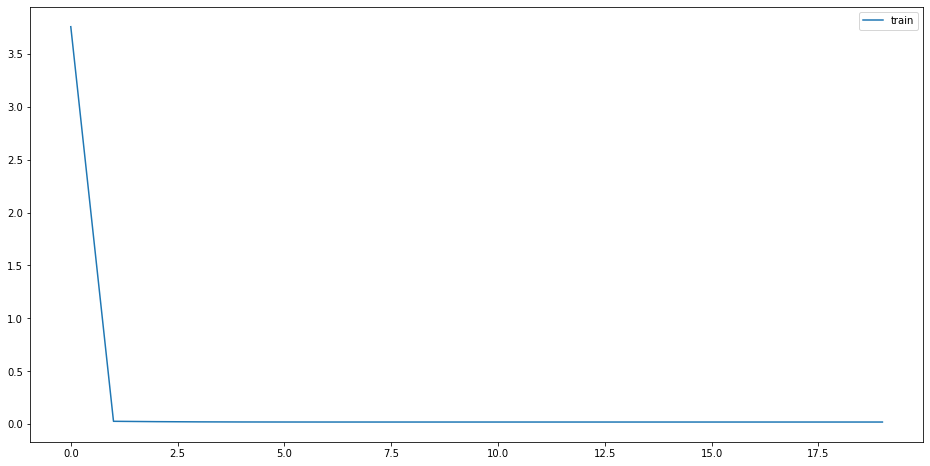

In [55]:
model,history = CNN1D_model(X_train1,Y_train_scaled,X_test1,Y_test_scaled)

plt.plot(history.history['loss'],label ='train')
plt.legend()
plt.show()


In [56]:
def pred_data(X1):
    
    Y_pred = model.predict(X1)
    
    return Y_pred

In [57]:
def Inverse_scale(Y):
    
    Y1_pred = scaler.inverse_transform(Y)
    
    return Y1_pred

30326/30326 [==============================] - 4s 138us/step
[0.019667275817976976, 0.11349315941333771]


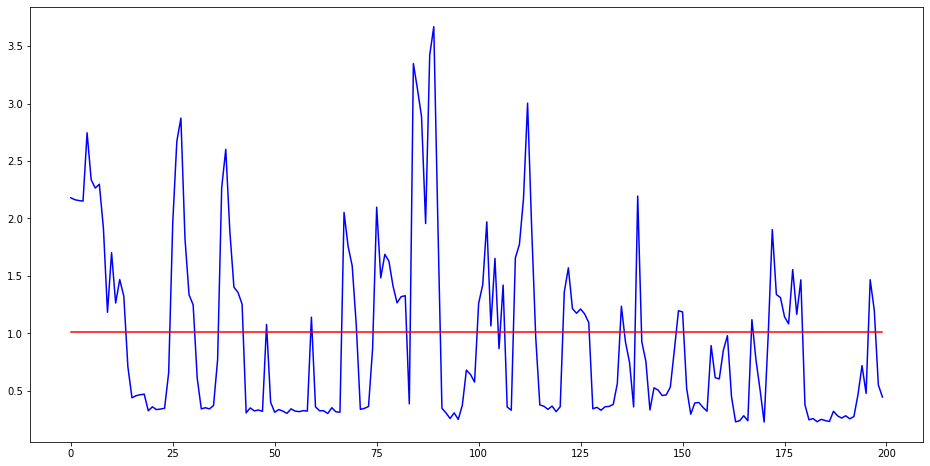

In [58]:
Y_train_pred = pred_data(X_train1)
Y_train_pred_desc = Inverse_scale(Y_train_pred)
Y_train_act_desc = Inverse_scale(Y_train_scaled)
results = model.evaluate(X_train1, Y_train_scaled, batch_size=128)
print(results)
plt.plot(Y_train_act_desc[:,0][0:200],'-b')
plt.plot(Y_train_pred_desc[:,0][0:200],'-r')

In [60]:
Y_train_pred_desc

array([[1.010653],
       [1.010653],
       [1.010653],
       ...,
       [1.010653],
       [1.010653],
       [1.010653]], dtype=float32)

In [366]:
Y_pred = pred_data(X_test1)
Y_test_pred_desc = Inverse_scale(Y_pred)
Y_test_act_desc = Inverse_scale(Y_test_scaled)

In [367]:
results = model.evaluate(X_test1, Y_test_scaled, batch_size=128)
print(results)

3370/3370 [==============================] - 0s 39us/step
[0.006135156513841198, 0.05200677365064621]


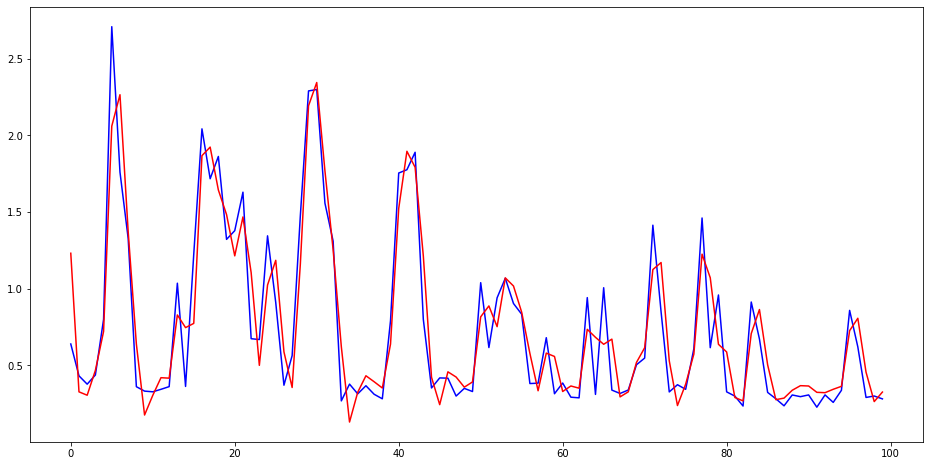

In [370]:
plt.plot(Y_test[:,1][0:100],'-b')
plt.plot(Y_pred_desc[:,1][0:100],'-r')